# **Finding Lane Lines on the Road** 
***
For this project, we needed to use the tools we learned in the lesson to identify lane lines on the road. The goal was to develop a pipeline on a series of individual images, and later apply the result to a video stream in order to identify the lane lines in the image.

First, we import packages and setup the notebook:

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

Next, we can take a look at one of the images we will be working with:

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


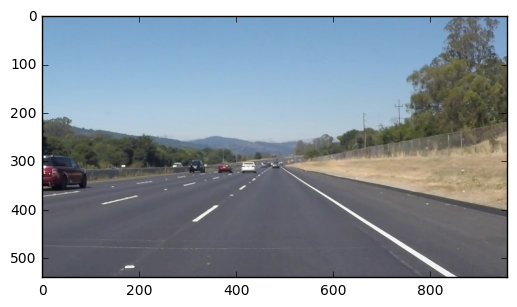

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

We need to load all the utility functions that will be used in the pipeline:

In [3]:
def reset_vars():
    """
    Reset the global variables used
    to smooth the change in the videos
    """
    global left
    global right
    left = np.array([0,0,0,0])
    right = np.array([0,0,0,0])

def grayscale(img):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """
    Applies the Canny transform
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian Noise kernel
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def extend_lines(segments, imshape):
    """
    For all of the lines in `segments`
    extend the lines to touch the borders
    of the image
    """
    for i in range(len(segments)):
        segments[i] = extend_line(segments[i], imshape)
    return segments


def extend_line(segment, imshape):
    """
    Extend the line to touch the
    border of the image or the top y
    which is a little below the middle
    """
    uppery = imshape[0]/2 + 100
    bottomy = imshape[0]

    x1, y1, x2, y2 = segment[0]
    if x1 == x2:
        return np.array([x1, uppery, x2, bottomy], int)
    if y1 == y2:
        return np.array([x1, 0, x2, imshape[1]], int)

    m = (y2-y1)/(x2-x1)
    b = y1 - m * x1

    # x = (y - b) / m
    x1 = (uppery - b) / m
    x2 = (bottomy - b) / m
    
    return np.array([x1, uppery, x2, bottomy], int)


def split_left_right(lines):
    """
    Separate lines that are
    inclined to the right to those
    that are inclined to the left.
    NOTE: right are the lines on the right
    which are inclined to the left and the
    converse is also true.
    """
    llines = np.zeros(shape=(0,4))
    rlines = np.zeros(shape=(0,4))
    
    for line in lines:
        x1,y1,x2,y2 = line[0]

        m = (y2-y1)/(x2-x1)
        if m < 0:
            llines = np.append(llines, [(x1, y1, x2, y2)], axis = 0)
        elif m > 0:
            rlines = np.append(rlines, [(x1, y1, x2, y2)], axis = 0)
    return np.expand_dims(llines, axis=1), np.expand_dims(rlines, axis=1)


def filter_lines(lines, imshape):
    """
    Intelligent manual filters to
    avoid processing lines that should not be
    considered.
    """
    
    flines = np.zeros(shape=(0,4))
    for line in lines:
        
        # extract and clamp the values
        x1,y1,x2,y2 = line[0]
        x1 = max(0, min(x1, imshape[1]))
        x2 = max(0, min(x2, imshape[1]))
        y1 = max(0, min(y1, imshape[0]))
        y2 = max(0, min(y2, imshape[0]))
        
        # filter horizontal lines
        if y1 == y2:
            continue

        # filter vertical lines
        if x1 == x2:
            continue
        
        # trim left lines
        if x1 < 125 or x2 < 125:
            continue
        
        # trim right lines
        if x1 > imshape[1] - 75 or x2 > imshape[1] - 75:
            continue
        
        # trim middle lines (250 - 750)
        if y1 == imshape[0] and x1 > 250 and x1 < 750:
            continue
        if y2 == imshape[0] and x2 > 250 and x2 < 750:
            continue
        
        # spike lines
        if y1 == 0 or y2 == 0:
            continue

        # slope control
        m = (y2-y1)/(x2-x1)
        # right [0.57046979865771807, 0.60070671378091878, 0.55555555555555558, 0.5821917808219178]
        # left [-0.78341013824884798, -0.74889867841409696, -0.77272727272727271, -0.74561403508771928]
        if m < 0 and (m < -0.8 or m > -0.6):
            continue
        
        if m > 0 and (m < 0.5 or m > 0.65):
            continue
        
        flines = np.append(flines, [(x1, y1, x2, y2)], axis = 0)

    return np.expand_dims(flines, axis=1)


def clean_outliers(lines, threshold = 2.):
    """
    Remove lines that are 2 std away
    from median to avoid outliers from
    having a strong effect
    """
    med = np.median(lines, axis = 0)
    adif = np.abs(lines - med)
    mdev = np.median(adif, axis = 0)
    s = np.divide(adif, mdev)
    s[np.isnan(s)] = 0
    return np.expand_dims(lines[np.all(np.less(s, threshold), axis = 2)], axis=1)

def smooth_line_change(current, new, ratio=0.95):
    """
    Control the ratio at which the lines 
    change position. The higher the ratio
    the smoother the change but also the
    longer it takes to adapt.
    """
    current[np.isnan(current)] = 0
    new[np.isnan(new)] = 0

    if np.sum(current) == 0:
        return new
    if np.sum(new) == 0:
        return current

    proposed = (1 - ratio) * new + ratio * current
    return proposed

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        line[np.isnan(line)] = 0
        x1, y1, x2, y2 = line.astype(int)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho = 2, theta = np.pi/180, threshold = 15, 
                min_line_len = 30, max_line_gap = 20):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    return line_img, lines

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def show_img(filename, pipeline = None, **kwargs):
    """
    Helper function to display an image.
    """
    image = mpimg.imread("test_images/" + filename) if pipeline is None \
        else pipeline(img=mpimg.imread("test_images/" + filename), **kwargs) 
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    plt.show()

## Test on Images
***

First, we build the pipeline that we will be using to identify the lane lines:

In [4]:
def process_image(img, **kwargs):
    """
    Lane Line Detection processing pipeline.
    """
    
    global left
    global right
    imshape = img.shape
    
    # gray, blur and canny image
    gray = grayscale(img)
    blured = gaussian_blur(gray, 5)
    cannied = canny(blured, 10, 100)
    
    # mask image to get only the region of interest
    # and calculate the hough lines
    vertices = np.array([[
            (100,imshape[0]),
            (imshape[1]/2 - 50, imshape[0]/2 + 50),
            (imshape[1]/2 + 50, imshape[0]/2 + 50), 
            (imshape[1] - 50,imshape[0])
        ]], dtype=np.int32)
    selected = region_of_interest(cannied, vertices)
    line_img, raw_lines = hough_lines(selected)
    
    # draw the raw lines if selected
    if kwargs.get('raw', False):
        for line in raw_lines:
            draw_lines(line_img, line, color=[0,0,200], thickness=2)
    
    # grab raw lines and extend them to use the entire image space
    extended_lines = extend_lines(raw_lines, imshape)
    
    # draw these extended lines if selected
    if kwargs.get('extended', False):
        for line in extended_lines:
            draw_lines(line_img, line, color=[0,200,0], thickness=2)
    
    # grab extended lines and filter with knowledge-based intelligence
    filtered_lines = filter_lines(extended_lines, imshape)
    
    # draw the filtered lines if selected
    if kwargs.get('filtered', False):
        for line in filtered_lines:
            draw_lines(line_img, line, color=[0,100,200], thickness=2)

    # split left and right lines and remove outliers
    llines, rlines = split_left_right(filtered_lines)
    llines = clean_outliers(llines)
    rlines = clean_outliers(rlines)
    
    # draw standardize lines if selected
    if kwargs.get('standards', False):
        for line in llines:
            draw_lines(line_img, line, color=[200,100,0], thickness=2)
        for line in rlines:
            draw_lines(line_img, line, color=[200,100,0], thickness=2)
    
    # smooth the change in lane
    left = smooth_line_change(left, np.median(llines, axis=0))
    right = smooth_line_change(right, np.median(rlines, axis=0))
    
    # draw the smooth lines if selected
    # note that these lines should be the final lines
    if kwargs.get('smooth', True):
        draw_lines(line_img, left, color=[255,0,0], thickness=15)
        draw_lines(line_img, right, color=[255,0,0], thickness=15)
    
    # blend the line image with the original image
    blended = weighted_img(line_img, img)
    return blended

Lets look at our current pipeline into detail. This is the original image we will be demostrating:

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


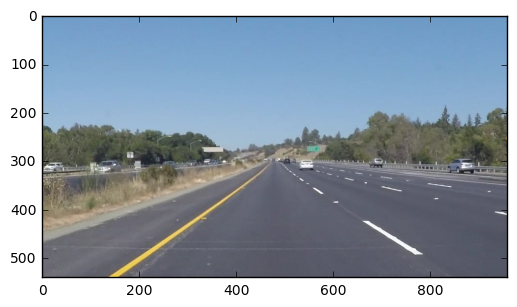

In [5]:
reset_vars()
filename = 'solidYellowLeft.jpg'
show_img(filename)

Next, we gray the image, canny it and apply hough transform into a selected area:

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


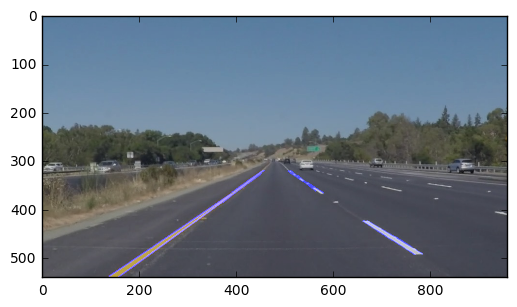

In [6]:
show_img(filename, process_image, raw=True, smooth=False)

Next, we extend and trim the lines so that they all extend from the bottom of the image to somewhere near the middle.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


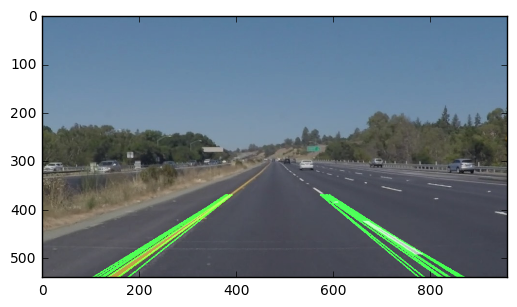

In [7]:
show_img(filename, process_image, extended=True, smooth=False)

Next, we filter the lines that are too far to the left, to far to the right, vertical, horizontal or even those that have a rare slope.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


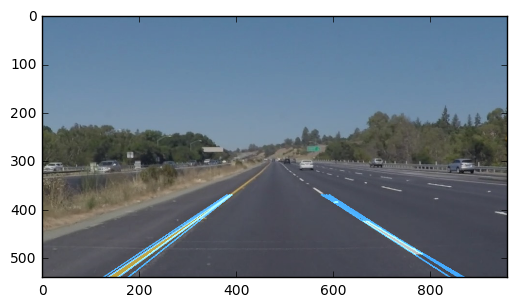

In [8]:
show_img(filename, process_image, filtered=True, smooth=False)

We further remove lines by standardizing them within 2 deviations.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


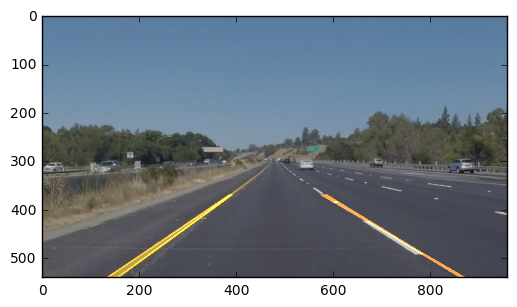

In [9]:
show_img(filename, process_image, standards=True, smooth=False)

Lastly, we calculate the mean of the probable lines and come up with a smooth mean line.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


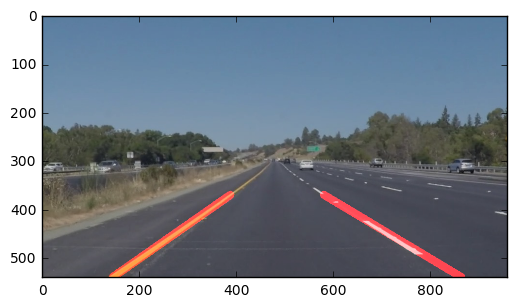

In [10]:
show_img(filename, process_image)

Let's take a look at the processed images on all different original images. 

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


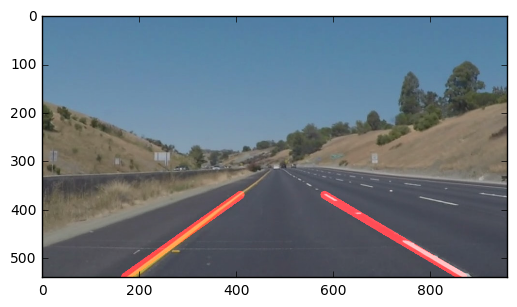

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


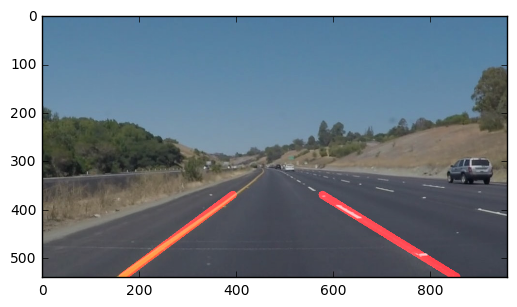

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


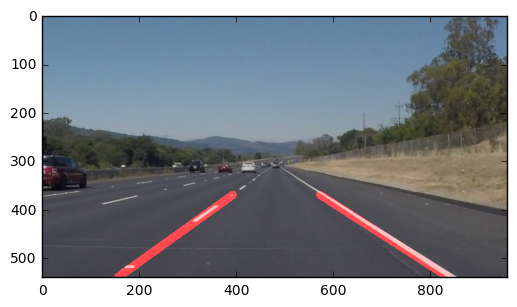

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


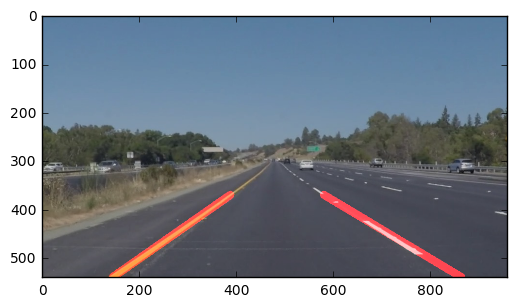

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


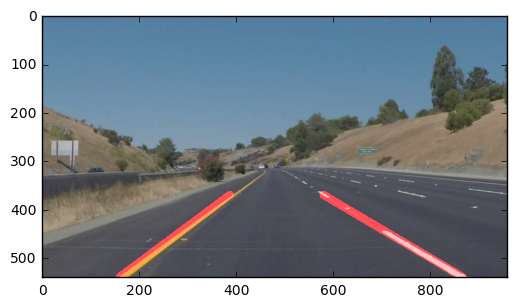

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


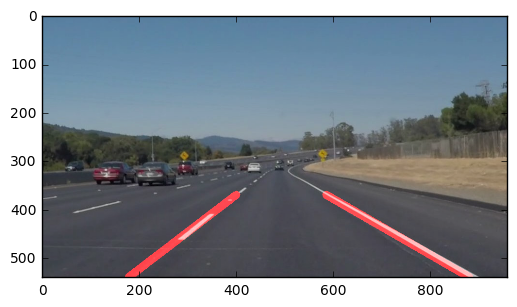

In [11]:
for filename in os.listdir("test_images/"):
    reset_vars()
    show_img(filename, process_image)

## Test on Videos
***

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

`challenge.mp4`

Let's try the one with the solid white lane on the right first.

In [12]:
reset_vars()
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 19.8 s, sys: 220 ms, total: 20.1 s
Wall time: 6.93 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left.

In [14]:
reset_vars()
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:25<00:00, 27.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 12s, sys: 620 ms, total: 1min 12s
Wall time: 25.6 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Finally, we try the pipeline against the challenge video.

In [16]:
reset_vars()
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:16<00:00, 14.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 50.9 s, sys: 470 ms, total: 51.3 s
Wall time: 17.7 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Reflections


#### How could you imagine making your algorithm better / more robust?  
Absolutely! One immediate improvement is to track a confidence level. If we would use a probabilistic approach to detect the lines, we could react a little more gracefully with sudden changes like in the challenge video. We could detect the difference between the previous line detection and the current and if the change is too large, we would adjust our confidence level. This variable could then help us change the rate in which the line changes. For example, the lower the confidence, the quickly we should adopt new values, the higher the confidence, the more conservative we should be when drawing the new lines. 

#### Where will your current algorithm be likely to fail?
At the moment the algorithm have a very high conservation rate with helps a lot to prevent drastic changes to show in the solution, but also fails to calculate the correct lines when they change position too rapidly. Because the videos provided are all from a highway run, the turning angles are not as large as they would on the city. This, doesn't require as much change in lines as they would in cities. Therefore, the conservative approach works fine, but if this was a city drive with sharp turns then the algorithm would be likely to hold too far to the previous line position failing to correctly identify the actual line.

#### Additional thoughts
Other things that I noticed affected the stability of the algorithm are the road reflectors and the change of the asphalt to concrete and concrete to asphalt. To stabilize the road reflectors the main adjustment made was during the hough transform. Although the solution is quite good, there could have been great improvements if time is invested in finding the best parameters. On the other hand the change on the road from asphalt to concrete and viceversa was handled by applying a filter that removes lines with slope close to zero which indicates horizontal lines. This is an acceptable solution, especially because we are not using deep learning in this project. However, there could be better ways to solve this problem by applying more artificial intelligence and less human intervention. Looking forward to seeing that.